# 1 - Imports + Preparation

In [1]:
import torch
import numpy as np
import spyrit.misc.walsh_hadamard as wh

from matplotlib import pyplot as plt

#from spyrit.learning.model_Had_DCAN import *
from spyrit.former.model_Had_DCAN import *
from spyrit.misc.disp import torch2numpy, imagesc, plot
from spyrit.learning.nets import *
from spyrit.misc.metrics import psnr_



In [2]:
#plt.rcParams['text.usetex'] = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Torch device: {device}')

Torch device: cuda:0


In [3]:
#%% Spectral binning (and checking a few things)
def subsample(spectral_data, CR):
    # If only one wavelength is considered
    if spectral_data.ndim == 1:
        torch_img = np.zeros((2*CR))
        
        pos = spectral_data[0::2][:CR]
        neg = spectral_data[1::2][:CR]
        
        torch_img[0::2] = pos
        torch_img[1::2] = neg
    
    # If spectral_data contains  all wavelengths
    if spectral_data.ndim == 2:
        
        torch_img = np.zeros((2*CR, spectral_data.shape[1]))
        
        pos = spectral_data[0::2][:CR,:]
        neg = spectral_data[1::2][:CR,:]
        
        torch_img[0::2,:] = pos
        torch_img[1::2,:] = neg
    
    return torch_img


def meas2img_from_ind(meas, ind, N):
    """Return image from measurement vector

    Args:
        meas (ndarray): Measurement vector. Must be 1-D.
        ind (ndarray):  Pattern indices. Must be 1-D.
        N (int):        Returned image will be N x N

    Returns:
        Img (ndarray): Measurement image. 2-D array
    """
    y = np.pad(meas, (0, N**2-len(meas)))
    Perm = permutation_from_ind(ind+1)
    Img = (Perm @ y).reshape((N, N))
    return Img

def completion(meas, M, Perm, Cov, Mean):
    
    nx, ny = Mean.shape
    
    # reorder measurements and statistics
    y     = Perm @ (meas.ravel())
    mu    = Perm @ (Mean.ravel())
    Sigma = Perm @ Cov @ Perm.T
    
    # extract blocks corresponding to acquired and missing measurements 
    mu1 = mu[:M]            # mean of acquired measurements
    mu2 = mu[M:]            # mean of missing measurements
    Sigma1  = Sigma[:M,:M]  # covariance of acquired measurements
    Sigma21 = Sigma[M:,:M]  # covariance of missing measurements

    m = y[:M];
    
    # Bayesian denoised completion
    #y1 = mu1 + W1 @ ( m - mu1)
    y1 = m
    #y2 = mu2 + Sigma21 @ np.linalg.lstsq(Sigma1,(y1 - mu1), rcond=None)[0]
    y2 = Sigma21 @ np.linalg.lstsq(Sigma1, y1, rcond=None)[0]
    #y2 = Sigma21 @ np.linalg.inv(Sigma1) @ y1
    y[:M] = y1
    y[M:] = y2
    
    # reorder output
    y = Perm.T @ y
    y = np.reshape(y,(nx, ny))
    
    return y

def unsplit(raw):
    had = raw[0::2] - raw[1::2]
    return had



# 2 - $CR = 1/2$
## 2.1 - Parameters and Neural Network

In [4]:
#%% Load reconstrcution network
img_size = 64
net_arch = 0 # Network variant
CR = 2048;

# Intensity distribution
N0 = 10
sig = 0

In [5]:
H = wh.walsh2_matrix(img_size) / img_size
data_folder = '../2022_OE_spyrit2/data_online/'
Mean = np.load(data_folder + 'Average_64x64.npy')/img_size
Cov  = np.load(data_folder + 'Cov_64x64.npy')/img_size**2

In [6]:
Var = Cov2Var(Cov);
Perm = Permutation_Matrix(Var);
H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];

In [7]:
n_iter = 4;
net_arch = 0;
model_root = '../2022_SPIE/models/'
title = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_2048_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi = DConvNet();
denoi = sn_dp_iteratif_2(CR, img_size, Cov,H, denoi, n_iter = n_iter)
model = DenoiCompNet(img_size, CR, Mean, Cov, net_arch, N0, sig, H, denoi=denoi);
model.recon.completion_layer.weight.requires_grad = False;
model.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model = model.to(device);
load_net(title, model,device);
model.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../2022_SPIE/models/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_2048_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=2048, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=2048, out_features=4096, bias=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# 2.2 - Tomato slice zoom x1

### 2.2.1 - Loading data and visualising

In [8]:
f = np.load(data_folder + 'tomato_slice_x1/tomato_slice_2_zoomx1_had_reco.npz')
raw = np.load(data_folder + 'tomato_slice_x1/tomato_slice_2_zoomx1_spectraldata.npz')

spectral_data = f['arr_0']
raw_data_h = raw['spectral_data']


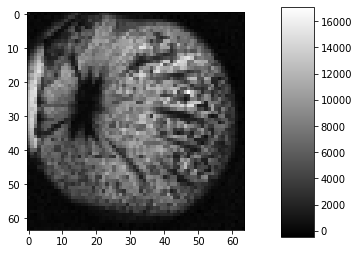

In [9]:
img_GT_all_Channels = np.sum(raw_data_h, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
# img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

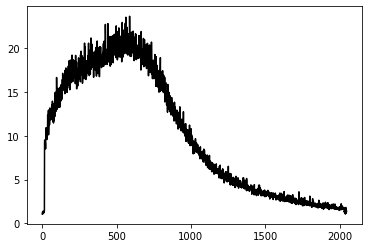

In [10]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

### 2.2.2 - Reconstructing using spyrit v1.2

In [11]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [12]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model.N0 = recon_pinv.max()
    result_mmse = model.forward_reconstruct_mmse(
        m, 1, 1, img_size, img_size, 
    )
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result
    
#np.save("./results_OE/tomato_x1_pinv_{}".format(CR), cube_pinv);
#np.save("./results_OE/tomato_x1_mmse_{}".format(CR), cube_mmse);
#np.save("./results_OE/tomato_x1_em_net_{}".format(CR), cube_em_net);

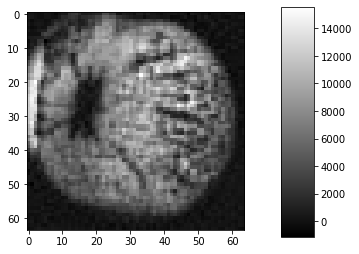

In [13]:
imagesc(np.sum(cube_pinv, axis = 0))

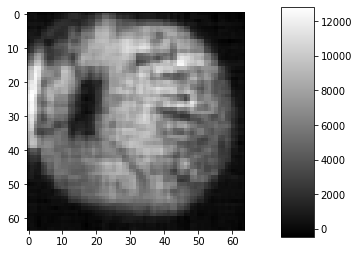

In [14]:
imagesc(np.sum(cube_mmse, axis = 0))

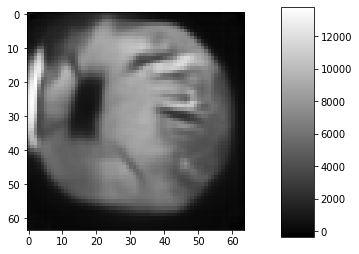

In [15]:
imagesc(np.sum(cube_em_net, axis = 0))

# 2.2 - Tomato slice zoom x1

### 2.2.2 - Reconstruction with Spyrit v2

In [16]:
from spyrit.restructured.Updated_Had_Dcan import *
#H *= img_size
H =  wh.walsh2_matrix(img_size)
Cov *= img_size**2

Hperm = Perm@H
Pmat = Hperm[:CR,:]
Cov_perm = Perm @ Cov @ Perm.T

Forward = Split_Forward_operator_ft_had(Pmat, Perm)
Noise = Bruit_Poisson_approx_Gauss(N0, Forward)
Prep = Split_diag_poisson_preprocess(N0, CR, img_size**2)
DC = Generalized_Orthogonal_Tikhonov(sigma_prior = Cov_perm, M = CR, 
                                     N = img_size**2)
Denoi = ConvNet()
model_v2 = DC_Net(Noise, Prep, DC, Denoi)
model_v2.eval()                    # Mandantory when batchNorm is used
model_v2.to(device)

DC_Net(
  (Acq): Bruit_Poisson_approx_Gauss(
    (FO): Split_Forward_operator_ft_had(
      (Hsub): Linear(in_features=4096, out_features=2048, bias=False)
      (Hsub_adjoint): Linear(in_features=2048, out_features=4096, bias=False)
      (Hpos_neg): Linear(in_features=4096, out_features=4096, bias=False)
      (Perm): Linear(in_features=4096, out_features=4096, bias=False)
    )
  )
  (PreP): Split_diag_poisson_preprocess()
  (DC_layer): Generalized_Orthogonal_Tikhonov(
    (comp): Linear(in_features=2048, out_features=2048, bias=False)
    (denoise_layer): Denoise_layer(in_features=2048)
  )
  (Denoi): ConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

In [17]:
cube_pinv = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_em_net = np.zeros((raw_data_h.shape[1],img_size, img_size));
cube_mmse = np.zeros((raw_data_h.shape[1],img_size, img_size));

In [18]:
for index in range(raw_data_h.shape[1]):
    #print(index)
    raw_data = raw_data_h[:,index];
    m_raw_data = raw_data[:2*CR];

    raw_unsplit = raw_data[0::2] - raw_data[1::2];
    recon_pinv = np.dot(np.transpose(H_k), raw_unsplit);
    recon_pinv = (1/img_size**2)*np.reshape(recon_pinv, (img_size, img_size))

    # imagesc(recon_pinv)

    m = torch.Tensor(m_raw_data);
    m = m.view(1,1,2*CR).to(device);

    ### Pseudo-inverse reconstruction
    model.N0 = recon_pinv.max();
    x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
    x_inv = (x_inv+1) * recon_pinv.max()/2
    x_inv = x_inv.cpu().detach().numpy().squeeze()
    cube_pinv[index,:,:] = x_inv;

    ### MMSE
    model_v2.PreP.N0 = recon_pinv.max()
    result_mmse = model_v2.reconstruct_mmse(m)
    result_mmse = (result_mmse+1) * recon_pinv.max()/2
    result_mmse = result_mmse.cpu().detach().numpy().squeeze()
    cube_mmse[index,:,:] = result_mmse;

    ### EM-Net
    model.N0 = recon_pinv.max()
    result = model.forward_reconstruct(
        m, 1, 1, img_size, img_size, 
    )
    result = (result+1) * recon_pinv.max()/2
    result = result.cpu().detach().numpy().squeeze()
    cube_em_net[index,:,:] = result
    
#np.save("./results_OE/tomato_x1_pinv_{}".format(CR), cube_pinv);
#np.save("./results_OE/tomato_x1_mmse_{}".format(CR), cube_mmse);
#np.save("./results_OE/tomato_x1_em_net_{}".format(CR), cube_em_net);

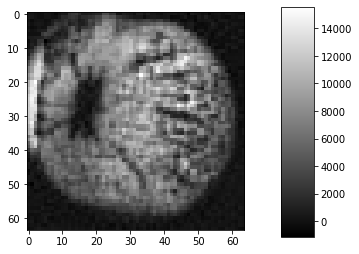

In [19]:
imagesc(np.sum(cube_pinv, axis = 0))

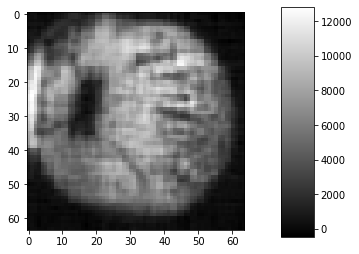

In [20]:
imagesc(np.sum(cube_mmse, axis = 0))

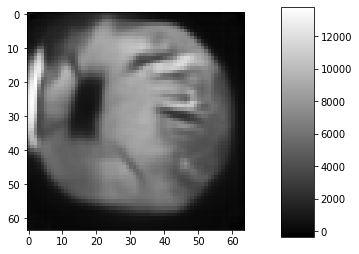

In [21]:
imagesc(np.sum(cube_em_net, axis = 0))